# 🎯 Classification Task

## 📚 Import necessary libraries

In [1]:
import os
import json
import random
import shutil
import zipfile
import subprocess
import matplotlib.pyplot as plt

from PIL import Image
from transformers import AutoModel

# Set seed for reproducibility
random.seed(42)

/home/student01/miniconda3/envs/my_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 📊 EDA

### 🧠 Brain Tumour

In [2]:
# Download Brain Tumour Classification
downloads_dir = 'Downloads'

subprocess.run([
    'curl', '-L', '-o', os.path.join(downloads_dir, 'brisc2025.zip'),
    'https://www.kaggle.com/api/v1/datasets/download/briscdataset/brisc2025'
])
print("Downloaded brisc2025.zip to", downloads_dir)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 88  248M   88  221M    0     0  24.4M      0  0:00:10  0:00:09  0:00:01 32.1M

Downloaded brisc2025.zip to Downloads


100  248M  100  248M    0     0  25.0M      0  0:00:09  0:00:09 --:--:-- 31.9M


In [3]:
# Unzip the downloaded file
data_path = 'Data'
unzip_path = os.path.join(downloads_dir, 'brisc2025.zip')

with zipfile.ZipFile(unzip_path, 'r') as zip_ref:
    zip_ref.extractall(data_path)
print(f"Extraction complete for {unzip_path} to {data_path}.")

Extraction complete for Downloads/brisc2025.zip to Data.


In [4]:
# Organize data into train, val, test splits
extract_dir = "Data/brisc2025/classification_task"

# Collect all images per class from Train and Test, resizing to 224x224
class_images = {}
for split in ['train', 'test']:
    split_path = os.path.join(extract_dir, split)
    for class_name in os.listdir(split_path):
        class_full_path = os.path.join(split_path, class_name)
        if os.path.isdir(class_full_path):
            if class_name not in class_images:
                class_images[class_name] = []
            for file in os.listdir(class_full_path):
                img = Image.open(os.path.join(class_full_path, file))
                img = img.resize((224, 224))
                class_images[class_name].append((os.path.basename(file), img))

# Remove original structure
shutil.rmtree(os.path.join(extract_dir, 'train'))
shutil.rmtree(os.path.join(extract_dir, 'test'))

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create directories and split files
splits = {'train': {}, 'val': {}, 'test': {}}
for class_name, images in class_images.items():
    random.shuffle(images)
    n = len(images)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    splits['train'][class_name] = images[:train_end]
    splits['val'][class_name] = images[train_end:val_end]
    splits['test'][class_name] = images[val_end:]
    
    # Create directories and save images
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(extract_dir, split, class_name), exist_ok=True)
        for name, img in splits[split][class_name]:
            img.save(os.path.join(extract_dir, split, class_name, name))

# Count samples
classes = list(class_images.keys())
train_samples = {cls: len(splits['train'][cls]) for cls in classes}
val_samples = {cls: len(splits['val'][cls]) for cls in classes}
test_samples = {cls: len(splits['test'][cls]) for cls in classes}

# Create config.json
config = {
    "classes": classes,
    "train_samples": train_samples,
    "val_samples": val_samples,
    "test_samples": test_samples,
    "image_size": 224
}

with open(os.path.join(extract_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("Data reorganized and config.json created.")

# Move the reorganized data to a new location and delete the original brisc2025 folder
new_dir = 'Data/brain_tumor'
shutil.move(extract_dir, new_dir)
shutil.rmtree('Data/brisc2025')
print(f"Moved reorganized data to {new_dir} and deleted original brisc2025 folder.")

Data reorganized and config.json created.
Moved reorganized data to Data/brain_tumor and deleted original brisc2025 folder.


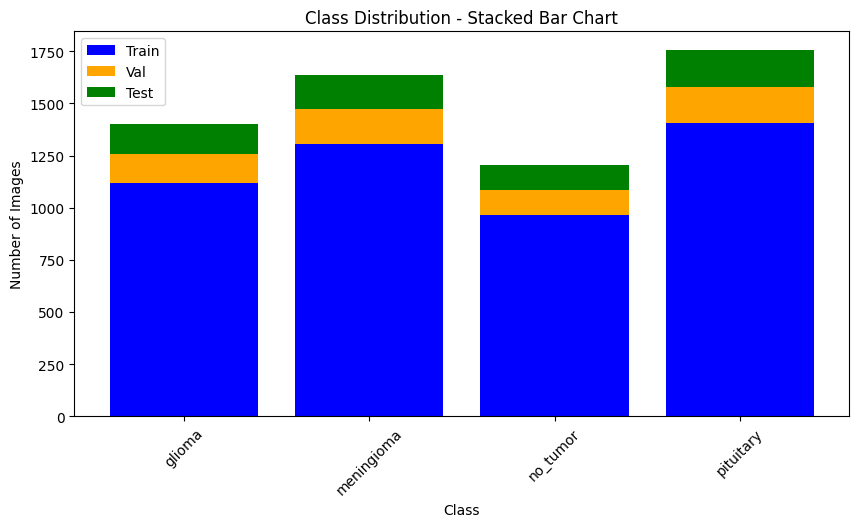

In [5]:
# Visualize class distribution
extract_dir = "Data/brain_tumor"

# Collect counts per split and class
splits = ['train', 'val', 'test']
class_counts = {}
for split in splits:
    split_path = os.path.join(extract_dir, split)
    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                if class_name not in class_counts:
                    class_counts[class_name] = {}
                class_counts[class_name][split] = count

# Stacked bar chart
classes = list(class_counts.keys())
train_counts = [class_counts[cls].get('train', 0) for cls in classes]
val_counts = [class_counts[cls].get('val', 0) for cls in classes]
test_counts = [class_counts[cls].get('test', 0) for cls in classes]

plt.figure(figsize=(10, 5))

plt.bar(classes, train_counts, label='Train', color='blue')
plt.bar(classes, val_counts, bottom=train_counts, label='Val', color='orange')
plt.bar(classes, test_counts, bottom=[train + val for train, val in zip(train_counts, val_counts)], label='Test', color='green')
plt.title('Class Distribution - Stacked Bar Chart')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend()

plt.show()

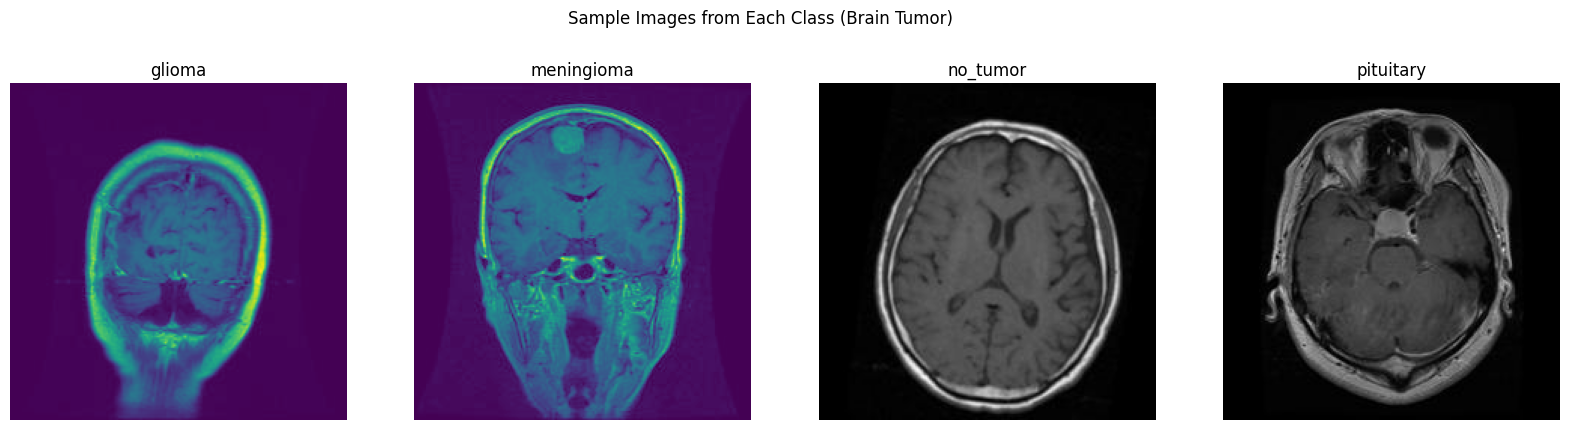

In [6]:
# Sample images from each class
extract_dir = "Data/brain_tumor"
train_dir = "Data/brain_tumor/train"

classes = os.listdir(train_dir)

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if images:
        img_path = os.path.join(class_path, images[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Class (Brain Tumor)')
plt.show()

### 🫁 Chest Xray

In [7]:
# Download Chest-Xray Classification
downloads_dir = 'Downloads'

subprocess.run([
    'curl', '-L', '-o', os.path.join(downloads_dir, 'chest-xray-pneumoniacovid19tuberculosis.zip'),
    'https://www.kaggle.com/api/v1/datasets/download/jtiptj/chest-xray-pneumoniacovid19tuberculosis'
])
print("Downloaded chest-xray-pneumoniacovid19tuberculosis.zip to", downloads_dir)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 99 1780M   99 1772M    0     0  28.9M      0  0:01:01  0:01:01 --:--:-- 28.0M

Downloaded chest-xray-pneumoniacovid19tuberculosis.zip to Downloads


100 1780M  100 1780M    0     0  28.9M      0  0:01:01  0:01:01 --:--:-- 27.3M


In [8]:
# Unzip the downloaded file
unzip_path = 'Downloads/chest-xray-pneumoniacovid19tuberculosis.zip'
extract_dir = "Data/chest-xray"

with zipfile.ZipFile(unzip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extraction complete for {unzip_path} to {extract_dir}.")

Extraction complete for Downloads/chest-xray-pneumoniacovid19tuberculosis.zip to Data/chest-xray.


In [9]:
# Organize chest-xray data into train, val, test splits (80/10/10)
extract_dir = 'Data/chest-xray'

# Collect all images per class from train, val, test, resizing to 224x224
class_images = {}
for split in ['train', 'val', 'test']:
    split_path = os.path.join(extract_dir, split)
    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            class_full_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_full_path):
                if class_name not in class_images:
                    class_images[class_name] = []
                for file in os.listdir(class_full_path):
                    img = Image.open(os.path.join(class_full_path, file))
                    img = img.resize((224, 224))
                    img = img.convert('RGB')  # Convert to RGB to avoid mode issues
                    class_images[class_name].append((os.path.basename(file), img))

# Remove original structure
for split in ['train', 'val', 'test']:
    split_path = os.path.join(extract_dir, split)
    if os.path.exists(split_path):
        shutil.rmtree(split_path)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create directories and split files
splits = {'train': {}, 'val': {}, 'test': {}}
for class_name, images in class_images.items():
    random.shuffle(images)
    n = len(images)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    splits['train'][class_name] = images[:train_end]
    splits['val'][class_name] = images[train_end:val_end]
    splits['test'][class_name] = images[val_end:]
    
    # Create directories and save images
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(extract_dir, split, class_name), exist_ok=True)
        for name, img in splits[split][class_name]:
            # Save as JPEG with .jpg extension
            base_name = os.path.splitext(name)[0]
            img.save(os.path.join(extract_dir, split, class_name, base_name + '.jpg'), 'JPEG')

# Count samples
classes = list(class_images.keys())
train_samples = {cls: len(splits['train'][cls]) for cls in classes}
val_samples = {cls: len(splits['val'][cls]) for cls in classes}
test_samples = {cls: len(splits['test'][cls]) for cls in classes}

# Create config.json
config = {
    "classes": classes,
    "train_samples": train_samples,
    "val_samples": val_samples,
    "test_samples": test_samples,
    "image_size": 224
}

with open(os.path.join(extract_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("Chest-xray data reorganized and config.json created.")

Chest-xray data reorganized and config.json created.


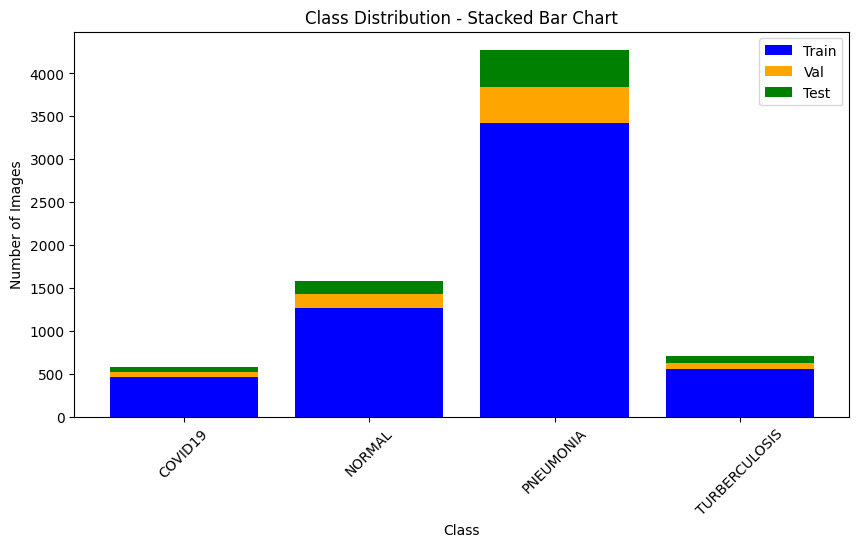

In [10]:
# Visualize class distribution
extract_dir = 'Data/chest-xray'

# Collect counts per split and class
splits = ['train', 'val', 'test']
class_counts = {}
for split in splits:
    split_path = os.path.join(extract_dir, split)
    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                if class_name not in class_counts:
                    class_counts[class_name] = {}
                class_counts[class_name][split] = count

# Stacked bar chart
classes = list(class_counts.keys())
train_counts = [class_counts[cls].get('train', 0) for cls in classes]
val_counts = [class_counts[cls].get('val', 0) for cls in classes]
test_counts = [class_counts[cls].get('test', 0) for cls in classes]

plt.figure(figsize=(10, 5))

plt.bar(classes, train_counts, label='Train', color='blue')
plt.bar(classes, val_counts, bottom=train_counts, label='Val', color='orange')
plt.bar(classes, test_counts, bottom=[train + val for train, val in zip(train_counts, val_counts)], label='Test', color='green')
plt.title('Class Distribution - Stacked Bar Chart')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend()

plt.show()

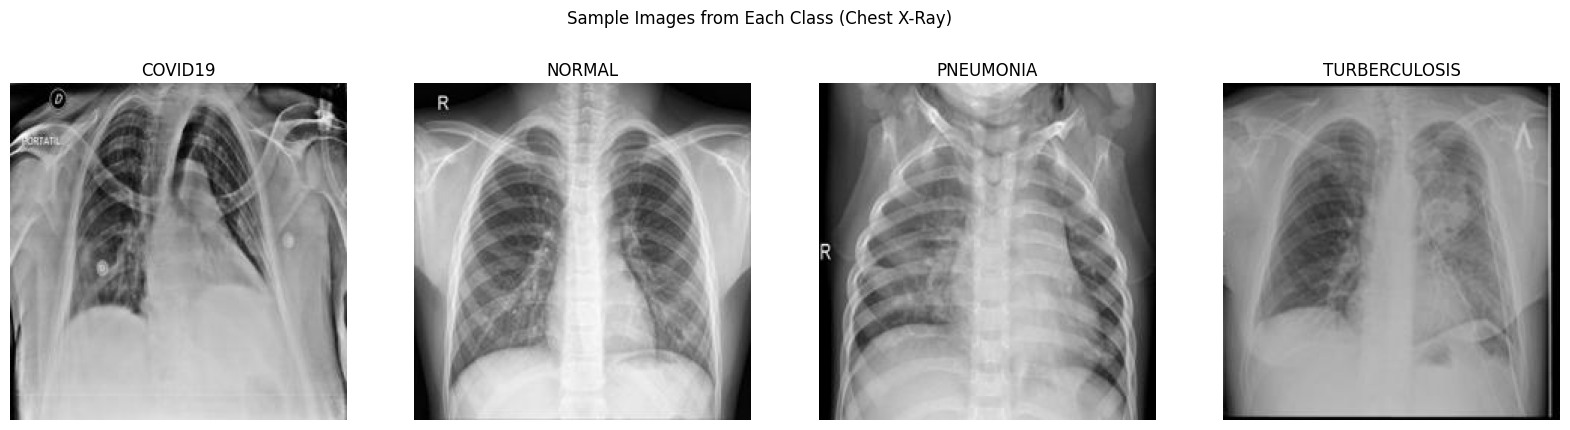

In [11]:
# Sample images from each class
extract_dir = 'Data/chest-xray'
train_dir = 'Data/chest-xray/train'

classes = os.listdir(train_dir)

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if images:
        img_path = os.path.join(class_path, images[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Class (Chest X-Ray)')
plt.show()

### 🧬 Lung Cancer (Histopathological)

In [12]:
# Download Chest-Xray Classification
downloads_dir = 'Downloads'

subprocess.run([
    'curl', '-L', '-o', os.path.join(downloads_dir, 'lung-cancer-histopathological-images.zip'),
    'https://www.kaggle.com/api/v1/datasets/download/rm1000/lung-cancer-histopathological-images'
])
print("Downloaded lung-cancer-histopathological-images.zip to", downloads_dir)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
 99 1590M   99 1580M    0     0  28.9M      0  0:00:55  0:00:54  0:00:01 29.7M

Downloaded lung-cancer-histopathological-images.zip to Downloads


100 1590M  100 1590M    0     0  28.9M      0  0:00:54  0:00:54 --:--:-- 29.9M


In [13]:
# Unzip the downloaded file
unzip_path = 'Downloads/lung-cancer-histopathological-images.zip'
extract_dir = 'Data/lung-cancer'

with zipfile.ZipFile(unzip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Extraction complete for {unzip_path} to {extract_dir}.")

Extraction complete for Downloads/lung-cancer-histopathological-images.zip to Data/lung-cancer.


In [14]:
# Organize lung-cancer data into train, val, test splits (80/10/10)
extract_dir = 'Data/lung-cancer'

# Collect all images per class, resizing to 224x224
class_images = {}
for class_name in os.listdir(extract_dir):
    class_path = os.path.join(extract_dir, class_name)
    if os.path.isdir(class_path):
        if class_name not in class_images:
            class_images[class_name] = []
        for file in os.listdir(class_path):
            img = Image.open(os.path.join(class_path, file))
            img = img.resize((224, 224))
            img = img.convert('RGB')  # Convert to RGB to avoid mode issues
            class_images[class_name].append((os.path.basename(file), img))

# Remove original class directories
for class_name in class_images.keys():
    class_path = os.path.join(extract_dir, class_name)
    if os.path.exists(class_path):
        shutil.rmtree(class_path)

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create directories and split files
splits = {'train': {}, 'val': {}, 'test': {}}
for class_name, images in class_images.items():
    random.shuffle(images)
    n = len(images)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)
    
    splits['train'][class_name] = images[:train_end]
    splits['val'][class_name] = images[train_end:val_end]
    splits['test'][class_name] = images[val_end:]
    
    # Create directories and save images
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(extract_dir, split, class_name), exist_ok=True)
        for name, img in splits[split][class_name]:
            # Save as JPEG with .jpg extension
            base_name = os.path.splitext(name)[0]
            img.save(os.path.join(extract_dir, split, class_name, base_name + '.jpg'), 'JPEG')

# Count samples
classes = list(class_images.keys())
train_samples = {cls: len(splits['train'][cls]) for cls in classes}
val_samples = {cls: len(splits['val'][cls]) for cls in classes}
test_samples = {cls: len(splits['test'][cls]) for cls in classes}

# Create config.json
config = {
    "classes": classes,
    "train_samples": train_samples,
    "val_samples": val_samples,
    "test_samples": test_samples,
    "image_size": 224
}

with open(os.path.join(extract_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

print("Lung-cancer data reorganized and config.json created.")

Lung-cancer data reorganized and config.json created.


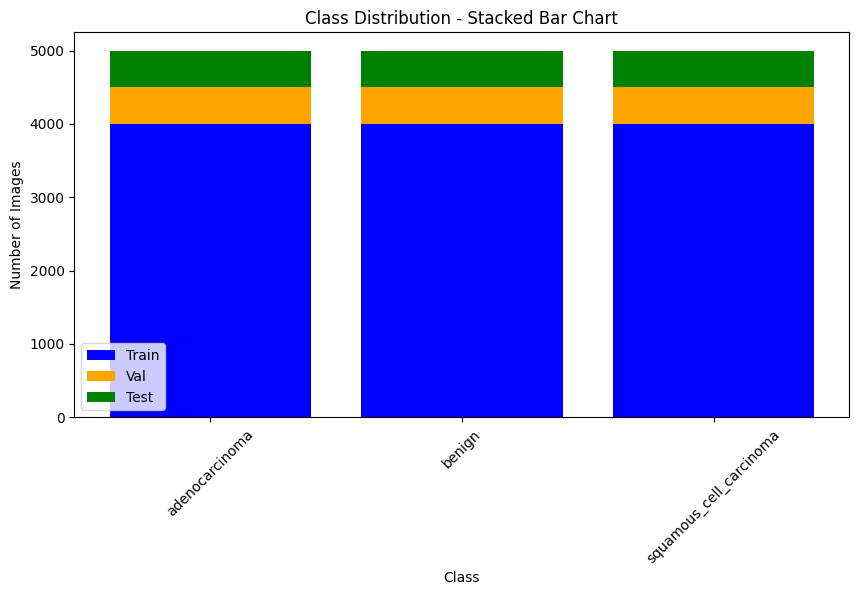

In [15]:
# Visualize class distribution
extract_dir = 'Data/lung-cancer'

# Collect counts per split and class
splits = ['train', 'val', 'test']
class_counts = {}
for split in splits:
    split_path = os.path.join(extract_dir, split)
    if os.path.exists(split_path):
        for class_name in os.listdir(split_path):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                if class_name not in class_counts:
                    class_counts[class_name] = {}
                class_counts[class_name][split] = count

# Stacked bar chart
classes = list(class_counts.keys())
train_counts = [class_counts[cls].get('train', 0) for cls in classes]
val_counts = [class_counts[cls].get('val', 0) for cls in classes]
test_counts = [class_counts[cls].get('test', 0) for cls in classes]

plt.figure(figsize=(10, 5))

plt.bar(classes, train_counts, label='Train', color='blue')
plt.bar(classes, val_counts, bottom=train_counts, label='Val', color='orange')
plt.bar(classes, test_counts, bottom=[train + val for train, val in zip(train_counts, val_counts)], label='Test', color='green')
plt.title('Class Distribution - Stacked Bar Chart')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.legend()

plt.show()

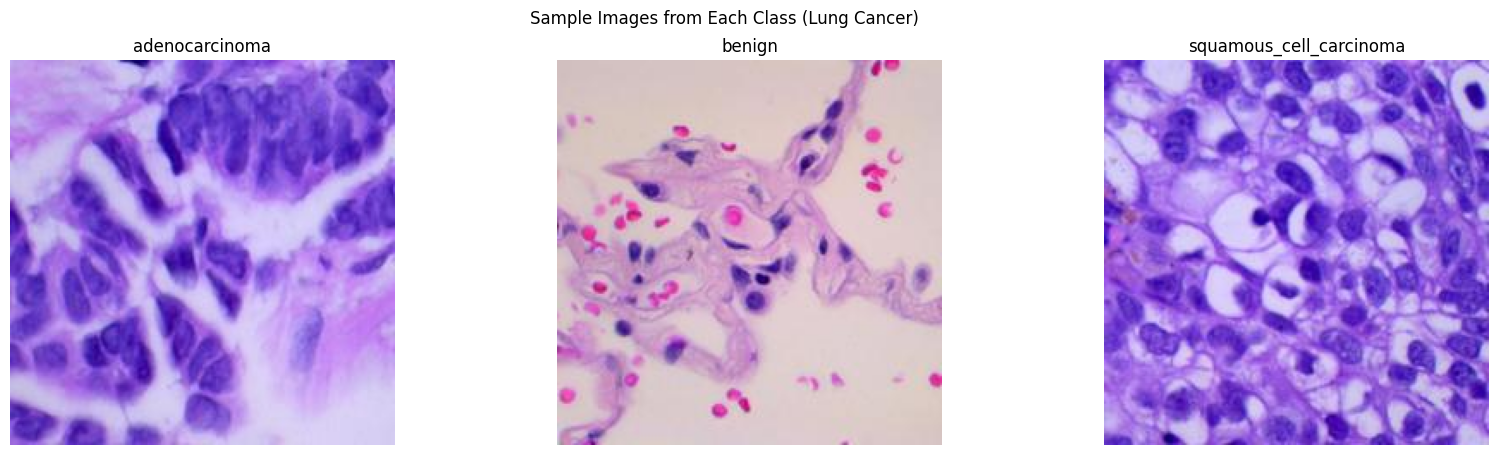

In [16]:
# Sample images from each class
extract_dir = 'Data/lung-cancer'
train_dir = 'Data/lung-cancer/train'

classes = os.listdir(train_dir)

fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_dir, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    if images:
        img_path = os.path.join(class_path, images[0])
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f'{class_name}')
        axes[i].axis('off')

plt.suptitle('Sample Images from Each Class (Lung Cancer)')
plt.show()

## 🤖 Model Preview CVT-13

In [17]:
# Model
model_name = "apple/mobilevit-small"
model = AutoModel.from_pretrained(model_name)

In [18]:
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Number of layers: {len(list(model.modules()))}")

Number of parameters: 4937632
Number of layers: 315


In [19]:
print(f"Model: {model_name}")
print(model)

Model: apple/mobilevit-small
MobileViTModel(
  (conv_stem): MobileViTConvLayer(
    (convolution): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (normalization): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): SiLU()
  )
  (encoder): MobileViTEncoder(
    (layer): ModuleList(
      (0): MobileViTMobileNetLayer(
        (layer): ModuleList(
          (0): MobileViTInvertedResidual(
            (expand_1x1): MobileViTConvLayer(
              (convolution): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (activation): SiLU()
            )
            (conv_3x3): MobileViTConvLayer(
              (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
              (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, 

In [20]:
print(f"Config: {model.config}")

Config: MobileViTConfig {
  "architectures": [
    "MobileViTForImageClassification"
  ],
  "aspp_dropout_prob": 0.1,
  "aspp_out_channels": 256,
  "atrous_rates": [
    6,
    12,
    18
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "conv_kernel_size": 3,
  "dtype": "float32",
  "expand_ratio": 4.0,
  "hidden_act": "silu",
  "hidden_dropout_prob": 0.1,
  "hidden_sizes": [
    144,
    192,
    240
  ],
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanu

## 📚 Datasets and Model References

### 🧠 Brain Tumor Segmentation and Classification (BRISC)
**Citation:**  
> Fateh, Amirreza; Rezvani, Yasin; Moayedi, Sara; Rezvani, Sadjad; Fateh, Fatemeh; Fateh, Mansoor.  
> *BRISC: Annotated Dataset for Brain Tumor Segmentation and Classification with Swin-HAFNet*.  
> arXiv preprint arXiv:2506.14318, 2025.  

- 📄 [Paper (arXiv)](https://arxiv.org/abs/2506.14318)  
- 📦 [Dataset (Kaggle)](https://www.kaggle.com/datasets/briscdataset/brisc2025)

---

### 🫁 Chest X-Ray (Pneumonia, COVID-19, Tuberculosis)
**Description:**  
Dataset containing chest X-ray images for multi-class classification: Normal/Pneumonia/Covid-19/Tuberculosis

- 📦 [Dataset (Kaggle)](https://www.kaggle.com/datasets/jtiptj/chest-xray-pneumoniacovid19tuberculosis)

---

### 🧬 Lung and Colon Cancer Histopathological Images (LC25000)
**Citation:**  
> Borkowski, A. A.; Bui, M. M.; Thomas, L. B.; Wilson, C. P.; DeLand, L. A.; Mastorides, S. M.  
> *Lung and Colon Cancer Histopathological Image Dataset (LC25000)*.  
> arXiv:1912.12142v1 [eess.IV], 2019.  

- 📄 [Paper (arXiv)](https://arxiv.org/abs/1912.12142v1)  
- 📦 [Dataset (Kaggle)](https://www.kaggle.com/datasets/rm1000/lung-cancer-histopathological-images)  
- 💻 [Source (GitHub)](https://github.com/tampapath/lung_colon_image_set)

---

### 🧩 Model: MobileViT (Mobile Vision Transformer)
**Citation:**  
> Mehta, Sachin; Rastegari, Mohammad.  
> *MobileViT: Light-weight, General-purpose, and Mobile-friendly Vision Transformer*. 2022.  

- 📄 [Paper (arXiv)](https://arxiv.org/abs/2110.02178)  
- 🤗 [Model (Hugging Face)](https://huggingface.co/apple/mobilevit-small)
